## Einleitung
Question and Answer Generation (QAG) ist ein wichtiger Anwendungsfall, bei dem automatisch Fragen und Antworten zu einem gegebenen Text generiert werden.
### Use-Case
QAG hat viele praktische Anwendungen:

- Content-Erstellung: QAG kann Content-Erstellern und Autoren dabei helfen, Inhalte effizienter zu erstellen. Anstatt manuell Fragen und Antworten zu einem Text zu formulieren, kann QAG dies automatisch erledigen.
- E-Learning: In Bildungseinrichtungen und E-Learning-Plattformen kann QAG verwendet werden, um Übungen und Quizfragen zu generieren, die das Verständnis der Schüler und Lernenden fördern.
- FAQ-Generierung: Unternehmen können QAG nutzen, um FAQs für ihre Produkte oder Dienstleistungen zu erstellen. Das spart Zeit und Ressourcen bei der Pflege von Kundenunterstützungsseiten.
- Chatbots und Virtual Assistants: QAG kann dazu verwendet werden, um Chatbots und virtuellen Assistenten die Fähigkeit zu geben, auf natürliche Weise gestellte Fragen zu beantworten.
### Zielsetzung

Die Zielsetzung ist: Die Entwicklung eines QAG-Modells, das in der Lage ist, qualitativ hochwertige Fragen und Antworten auf Texte von CNN (https://huggingface.co/datasets/StellarMilk/newsqa) zu generieren.

### Github Repo
Das für das Training verwendete Repository ist https://github.com/asahi417/lm-question-generation.

## Modellarchitektur (Jan)

Um den Use- Case möglichst gut abzudecken sind wir auf das Paper von Asahi Ushio and Fernando Alva-Manchego and Jose Camacho-Collados gestossen (https://arxiv.org/pdf/2305.17002.pdf), welches unterschiedliche QAG models vergleicht. 

Das beste beschriebene Modell aufgrund von der Metrik F1/exact match, welches in der Tabelle 2 beschrieben wird ist die T5- end-end Architektur. Zusätzlich zu den besseren Metriken sind die Trainingskosten beim end-end Aufbau besser.

### End-End Ansatz
Es gibt unterschiedliche QAG-Ansätze. In diesem Bericht wird der Ansatz End2End verwendet, welcher innerhalb eines Modelles und in "einem Schritt", sowohl die Frage, wie auch die Antwort erstellt.

<img src="./images/qag.png" alt="Aufbau" width="500">

### T5- Transformer

Der T5- Transformer wird im Paper "Exploring the Limits of Transfer Learning with a Unified
Text-to-Text Transformer" (https://jmlr.org/papers/volume21/20-074/20-074.pdf) beschrieben.

Diese Modelle werden vortrainiert, um dann auf Downstream Tasks angewendet werden zu können. Dabei werden alle Aufgabenstellungen als text-to-text Problem angesehen. Dadurch könnten sehr unterschiedliche Fragestellungen abgebildet werden.

<img src="./images/T5-Aufbau.png" alt="Aufbau" width="700">

Die Modellarchitektur ist sehr ähnlich wie der ursprüngliche Transformer (https://arxiv.org/pdf/1706.03762.pdf), es wurden aber einzelne Änderungen gemacht:
- Layer Normalization: Es wird nur eine vereinfachte Layer-Normalisierung verwendet, welche die Aktivierungen umskaliert, ohne additive Bias hinzuzufügen.
- Dropout: Es wird an unterschiedlichen stellen Dropout eingesetzt.
- Embedding: Der ursprüngliche Transformer verwendent ein Sinusförmiges Embedding oder ein gelerntes Positionsembedding. In diesem Aufbau wird ein relatives Positionsembedding verwendet.

Es gibt noch weitere kleinere Anpassungen. Im grossen und ganzen entspricht es der ursprünglichen Transformerarchitektur.

Dabei verwenden wir die folgenden Modellausführungen:

#### Modellgrössen

Es wurden die Small und Base Varianten untersucht. Diese haben folgende Parameter:

| Modeltyp | Output Dimensionalität MLP pro Block | Anzahl Encoder und Decoder Layer |sub-layers and embeddings Dimension|Anzahl Parameter|
| :----:   | :---:                                | :-------: |:-------:|:-------:|
| Small    | 2048                             |    6     |512|60 * 10^6|
| Base     | 3072                                  |    12   |768|220 * 10^6|

## Trainingsparameter mit Lossfunktion usw...

Während des Trainings wird auf eine Kreuzvalidierung verzichtet, da wir die Rechenkapazitäten des Slurm Cluster nicht überstrapazieren möchten. Um Fehler abschätzen zu können, wäre dies Sinnvoll.

In [2]:
import re
import pandas as pd
import seaborn as sns
# Specify the log file path
def get_best_model(log_file_path,ckpt_dir="small_trained"):
    ckpt_dir = f"{ckpt_dir}_ckpt"
    # Initialize the best model name variable
    best_model_name = None

    # Read the log file and extract the best model name
    with open(log_file_path, "r", encoding="UTF-8") as file:

        multiline_text = file.read()
    pattern = fr"creating {ckpt_dir}/best_model\n(.+?)\n"
    match = re.search(pattern, multiline_text, re.DOTALL)
    if match:
        model_path = match.group(1)
    else:
        print("Model path not found.")
    # Regular expression pattern
    pattern = fr"copying\s+(.*?)\/epoch_\d+\/\w+\.json\s+->\s+{ckpt_dir}/best_model$"

    # Search for the pattern in the line
    match = re.search(pattern, model_path)
    if match:
        model_path = match.group(1)
        return model_path
    else:
        print("Model path not found in the line.")


In [ ]:

def get_loss(log_file_path,best_model_name):
    # Initialize empty lists to store names, epochs, steps, and loss values
    names = []
    epochs = []
    steps = []
    loss_values = []

    # Define regular expression patterns to extract name, epoch, step, and loss values
    name_pattern = r"initialize checkpoint at (.+)"
    epoch_pattern = r"\[epoch (\d+)/"
    step_pattern = r"\(global step (\d+): loss: ([\d.]+), lr: ([\d.]+)"
    average_pattern = r'average loss:\s*([\d.]+)'
    average_losses = []
    epochs_for_avg_losses = []
    current_epoch = 0  # Initialize the current_epoch to 0
    current_name = None
    inside_target = False  # Flag to indicate if we are inside the target section
    # Read the log file and extract name, epoch, step, and loss values using regex
    with open(log_file_path, "r", encoding="UTF-8") as log_file:
        for line in log_file:
            name_match = re.search(name_pattern, line)
            if name_match:
                current_name = name_match.group(1)
            if f"{best_model_name}" in line:
                if inside_target:
                    break  # Stop if we reach the second occurrence of the target
                else:
                    inside_target = True  # Start recording when we find the first occurrence
                    continue

            if inside_target:
                epoch_match = re.search(epoch_pattern, line)
                step_match = re.search(step_pattern, line)
                # Find all matches in the text
                average_match = re.findall(average_pattern, line)

                # Extract the average loss if it's present in a line
                if average_match:
                    average_loss = float(average_match[0])
                    average_losses.append(average_loss)
                    epochs_for_avg_losses.append(current_epoch)
                if epoch_match:
                    current_epoch = int(epoch_match.group(1)) +1
                elif step_match:
                    step = int(step_match.group(1))
                    loss = float(step_match.group(2))
                    names.append(current_name)
                    epochs.append(current_epoch)
                    steps.append(step)
                    loss_values.append(loss)

    # Create a Pandas DataFrame
    data = {
        "Name": names,
        "Epoch": epochs,
        "Step": steps,
        "Loss": loss_values
    }

    df_steps = pd.DataFrame(data)
    data_avg_los = pd.DataFrame({
        "Epoch": epochs_for_avg_losses,

        "Loss": average_losses
    })

    return df_steps,data_avg_los


In [ ]:
log_file_path = "./slurm/logs/train_base_err.txt"
ckpt_dir = "base_trained"
name = get_best_model(log_file_path ,ckpt_dir=ckpt_dir)
df,average_loss = get_loss(log_file_path,name)

## Datengrundlage (Sowohl EDA wie auch beschreiben (newsqa usw.))

## Erroranalyse (min. 3 Stück) (Florin)

Evaluation Small -> welche Fehler macht das Modell?

In [3]:
import pandas as pd

# .\evaluation_small_trained\metric.first.answer.paragraph.questions_answers.StellarMilk_newsqa.default.json

folders = [
    "evaluation_small",
    "evaluation_small_trained",
    "evaluation_small_finetuned",
    "evaluation_small_combined_trained",
    "evaluation_small_trained",
]

# read all the json files and store them in a big dataframe
df_list = []
for folder in folders:
    df = pd.read_json(f"./{folder}/metric.first.answer.paragraph.questions_answers.StellarMilk_newsqa.default.json")
    df["Model"] = folder[11:]
    df_list.append(df)
    
df = pd.concat(df_list)
df = df.reset_index(names=["Metric"])
# Columns are: Metric	validation	test	Model
# unpivot the dataframe
df = df.melt(id_vars=["Metric","Model"],var_name="Dataset",value_name="Value")
# Columns are: Metric	Model	Dataset	Value
df.head()

,Metric,Model,Dataset,Value
0,Bleu_1,small,validation,0.255012
1,Bleu_2,small,validation,0.143018
2,Bleu_3,small,validation,0.082351
3,Bleu_4,small,validation,0.053557
4,ROUGE_L,small,validation,0.215815


In [39]:
# print all metrics
print(df.Metric.unique())

['Bleu_1' 'Bleu_2' 'Bleu_3' 'Bleu_4' 'ROUGE_L' 'BERTScore' 'MoverScore'
 'QAAlignedF1Score (BERTScore)' 'QAAlignedRecall (BERTScore)'
 'QAAlignedPrecision (BERTScore)' 'QAAlignedF1Score (MoverScore)'
 'QAAlignedRecall (MoverScore)' 'QAAlignedPrecision (MoverScore)']


d:\dev\npr_mc2\.venv\Lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


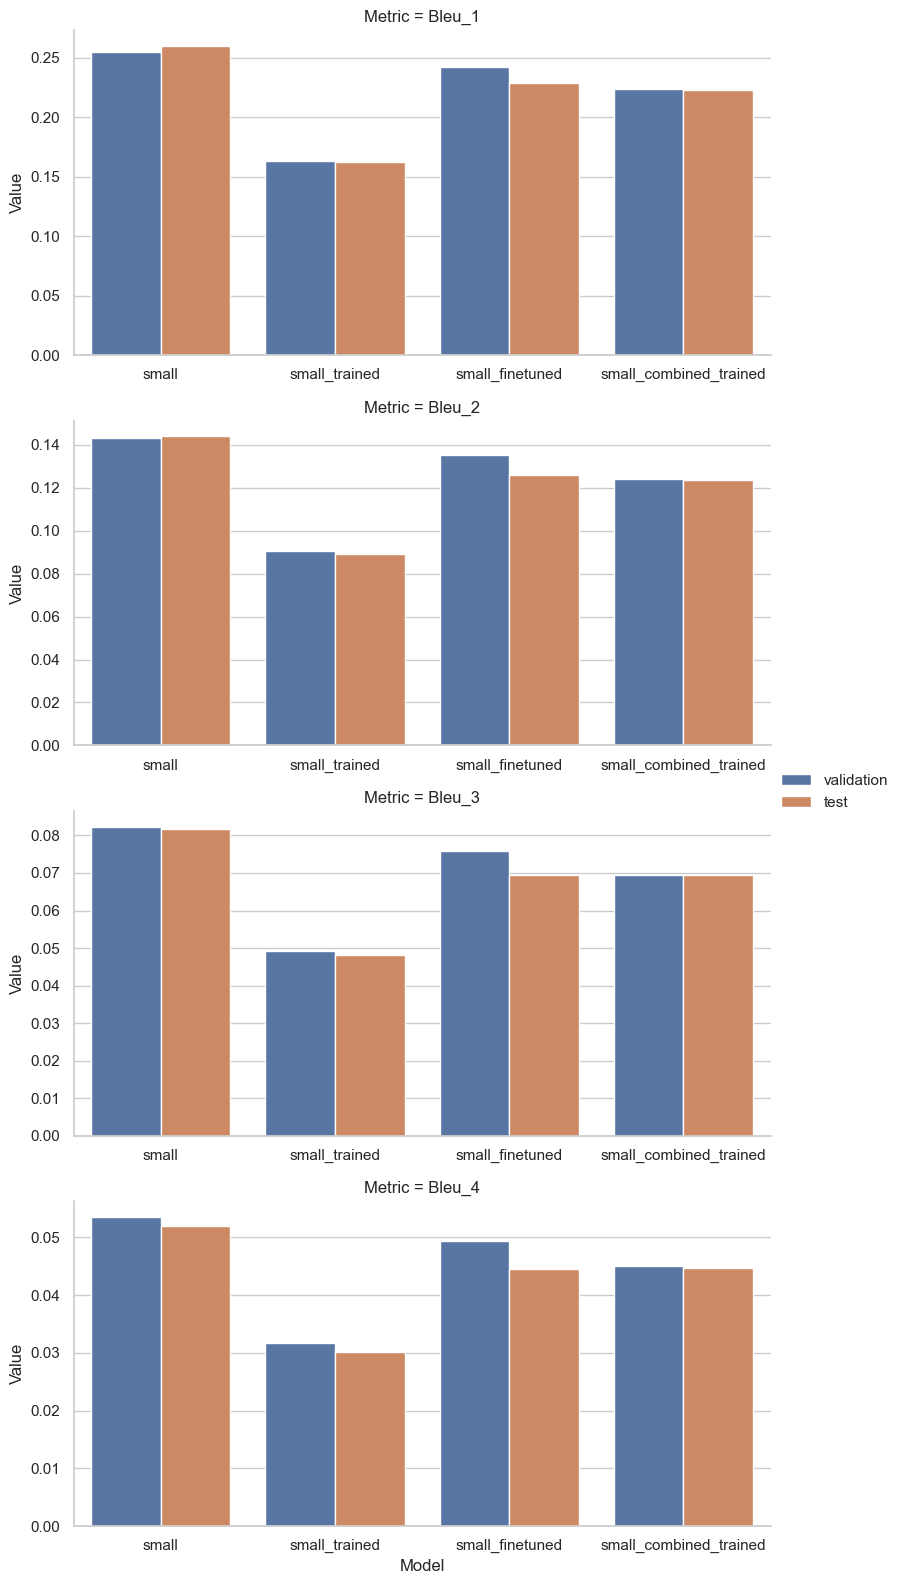

In [38]:
def plot_results(df):
    sns.set_theme(style="whitegrid")
    g = sns.FacetGrid(df, row="Metric", height=4, aspect=2, sharex=False, sharey=False)
    g.map(sns.barplot, "Model", "Value", "Dataset", palette="deep", order=["small","small_trained","small_finetuned","small_combined_trained","small_trained"])
    g.add_legend()

plot_results(df[df["Metric"].str.contains("Bleu")])

Erkenntnisse:
- small (baseline) ist immer am besten
- small_trained schneidet immer schlechter ab als alle anderen
- small_finetuned schneidet am besten ab von den selbst trainierten Modellen
- small_finetuned hat aber immer einen höheren Validation BLEU als Test BLEU
- small_combined_trained schneiden in validation und test etwa gleich ab wie small_finetuned im test


d:\dev\npr_mc2\.venv\Lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


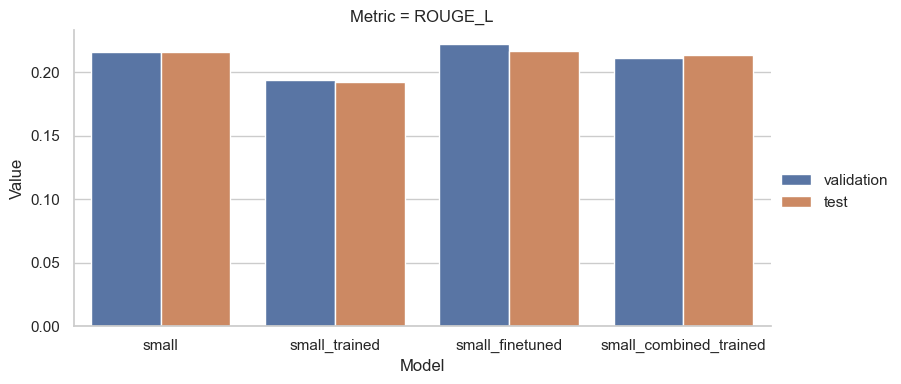

In [42]:
plot_results(df[df["Metric"] == "ROUGE_L"])

Erkenntnisse:
- ROUGE_L:
    - finetuned schneidet im Test vergleichbar mit baseline ab, Validation ist bisschen besser
    - trained wieder deutlich schlechter
    - combined_trained etwa gleich wie baseline

d:\dev\npr_mc2\.venv\Lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


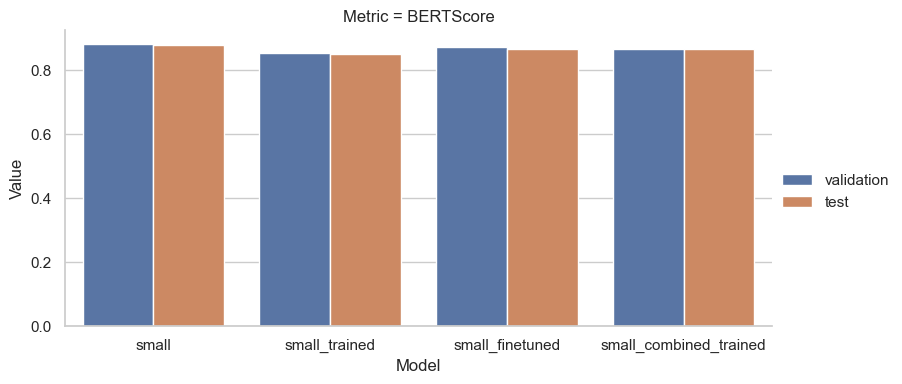

In [43]:
plot_results(df[df["Metric"] == "BERTScore"])

Erkenntnisse:
- BERTScore unterscheidet sich nicht wirklich zwischen den Modellen


d:\dev\npr_mc2\.venv\Lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


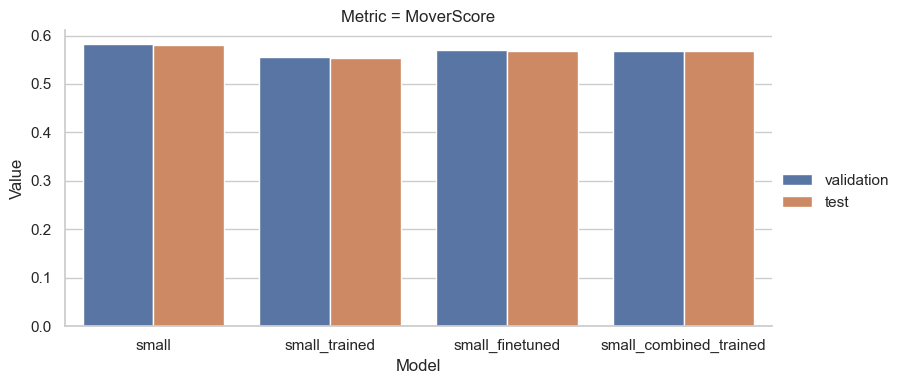

In [44]:
plot_results(df[df["Metric"] == "MoverScore"])

Erkenntnisse:
 - Alle schlechter als baseline
 - trained am schlechtesten
 - finetuned und combined_trained etwa gleich gut

d:\dev\npr_mc2\.venv\Lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


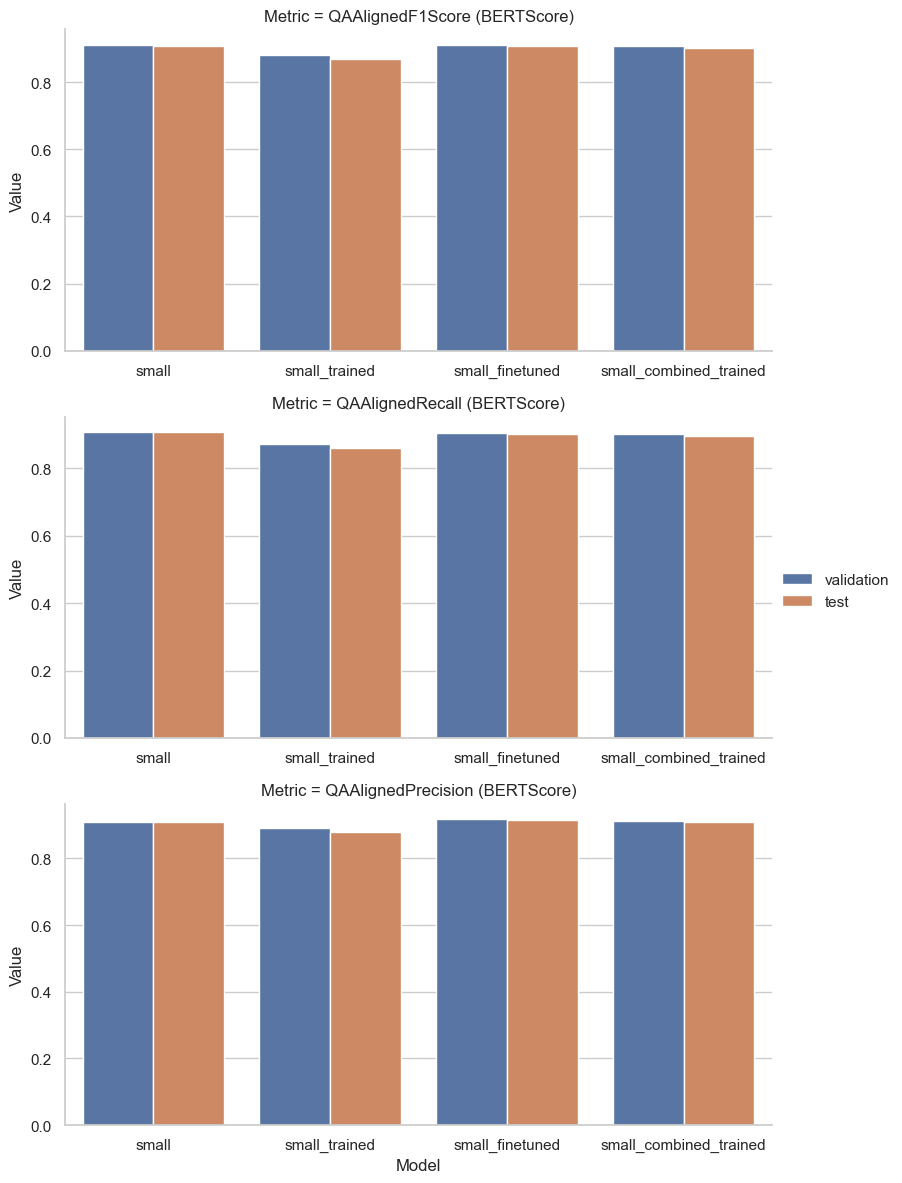

In [46]:
plot_results(df[df["Metric"].str.contains("(BERTScore)", regex=False)])

Sind in etwa alle gleich gut, trained immer ein wenig schlechter. Einzig bei Precision ist small_finetuned minimal besser als baseline.

d:\dev\npr_mc2\.venv\Lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


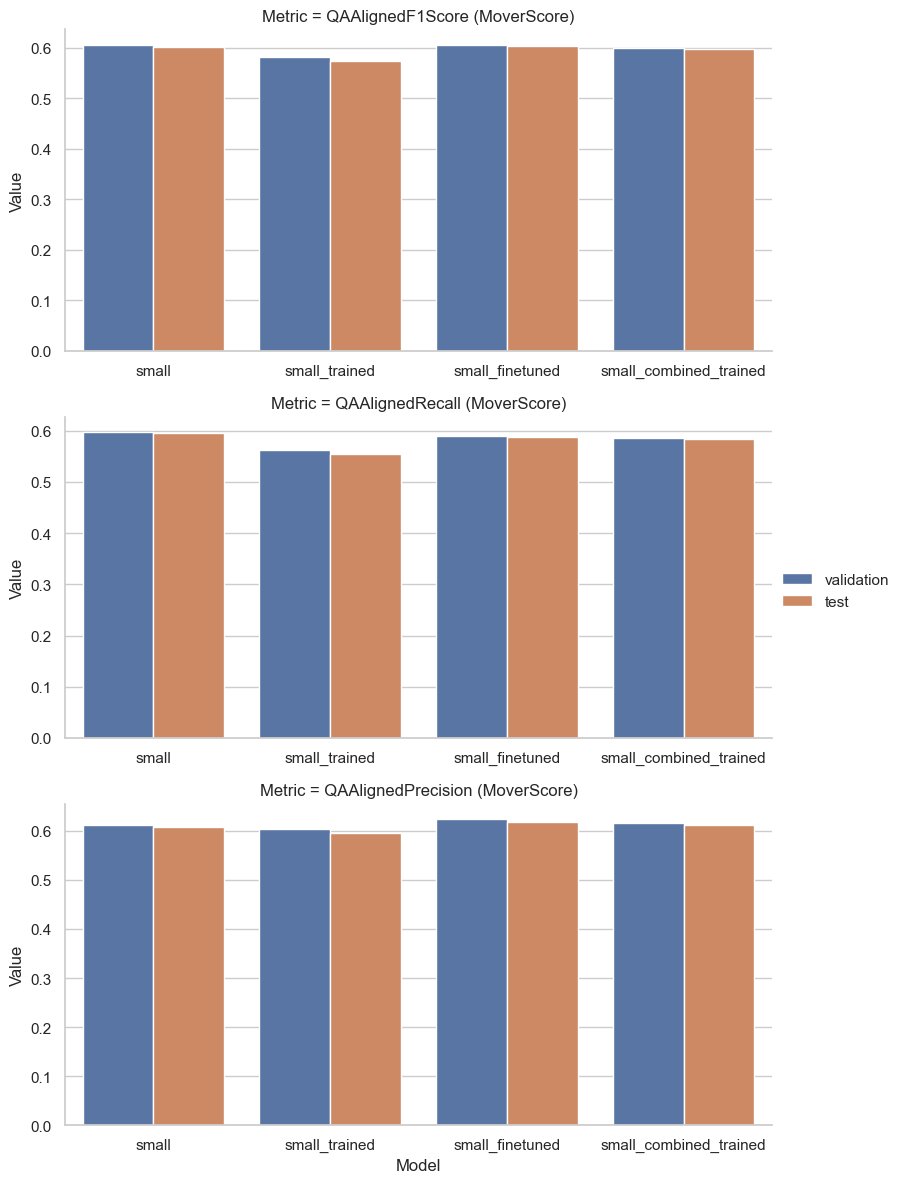

In [47]:
plot_results(df[df["Metric"].str.contains("(MoverScore)", regex=False)])

gleich wie bei BERTScore

### Qualitative Evaluation (Florin)
Wir evaluiren jeweils nur das beste Modell (small_finetuned) und vergleiche es wenn nötig mit dem baseline Modell.

In [4]:
from datasets import load_dataset

dataset = load_dataset("StellarMilk/newsqa")

In [5]:
dataset["test"][0]["paragraph"]

'WASHINGTON (CNN) -- President Obama urged Congress to adopt a "pay-as-you-go" approach to federal spending in order to restore fiscal discipline, but critics say the president\'s call lacks credibility.\n\n\n\nPreisdent Obama says PAYGO is common sense.\n\n\n\nFaced with a record $1.8 trillion deficit, Obama on Tuesday pushed Congress to take up the spending rules, known as PAYGO. The approach would require lawmakers to pay for new programs, dollar-for-dollar, with budget cuts elsewhere.\n\n\n\n"The \'pay as you go\' rule is very simple. Congress can only spend a dollar if it saves a dollar elsewhere," Obama said, as he announced that he was submitting to Congress a proposal to make PAYGO law.\n\n\n\nObama repeated his vow to halve the deficit by the end of his first term, and he said PAYGO is an important step toward making that happen. A previous PAYGO mandate helped erase federal budget deficits in the 1990s, and subsequent ineffective rules contributed to the current budget defici

In [6]:
def load_paragraphs(path):
    """
    Load paragraphs from a file and return a list of paragraphs. Each paragraph is a list of dictionaries with keys "Question" and "Answer".
    """
    paragraphs = []
    with open(path, "r", encoding="UTF-8") as file:
        for line in file:
            paragraphs.append(line)
            
    parsed_paragraphs = []
    failed_paragraphs = []
    for paragraph in paragraphs:
        q_and_as = []
        failed = False
        for q_and_a in paragraph.split(" | "):
            try:
                q_and_as.append({
                    "Question": q_and_a.split(", answer:")[0].split("question: ")[1].strip(),
                    "Answer": q_and_a.split(", answer:")[1].strip()
                })
            except IndexError:
                failed = True
                break
        parsed_paragraphs.append(q_and_as)
        failed_paragraphs.append(paragraph if failed else None)
    return parsed_paragraphs, failed_paragraphs


fine_tuned_paragraphs, fine_tuned_failed = load_paragraphs("./evaluation_small_finetuned/samples.test.hyp.paragraph.questions_answers.StellarMilk_newsqa.default.txt")
trained_paragraphs, trained_failed = load_paragraphs("./evaluation_small_trained/samples.test.hyp.paragraph.questions_answers.StellarMilk_newsqa.default.txt")
trained_combined_paragraphs, trained_combined_failed = load_paragraphs("./evaluation_small_combined_trained/samples.test.hyp.paragraph.questions_answers.StellarMilk_newsqa.default.txt")
baseline_paragraphs, baseline_failed = load_paragraphs("./evaluation_small/samples.test.hyp.paragraph.questions_answers.StellarMilk_newsqa.default.txt")

#### 1. Error: Wiederholung von gleichen Fragen

In [7]:
def print_paragraph(i):
    print("Paragraph context:")
    print(dataset["test"][i]["paragraph"].replace("\n\n", "\n").replace("\n\n", "\n"))
    print("------------------")
    print("\nGround truth answers:")
    for question, answer in zip(dataset["test"][i]["questions"], dataset["test"][i]["answers"]):
        print(question)
        print(answer)
        print("------------------")
    print("\nBaseline model answers:")
    for q_and_a in baseline_paragraphs[i]:
        print(q_and_a["Question"])
        print(q_and_a["Answer"])
        print("------------------")
    print("\nFine tuned model answers:")
    for q_and_a in fine_tuned_paragraphs[i]:
        print(q_and_a["Question"])
        print(q_and_a["Answer"])
        print("------------------")

print_paragraph(0)

Paragraph context:
WASHINGTON (CNN) -- President Obama urged Congress to adopt a "pay-as-you-go" approach to federal spending in order to restore fiscal discipline, but critics say the president's call lacks credibility.
Preisdent Obama says PAYGO is common sense.
Faced with a record $1.8 trillion deficit, Obama on Tuesday pushed Congress to take up the spending rules, known as PAYGO. The approach would require lawmakers to pay for new programs, dollar-for-dollar, with budget cuts elsewhere.
"The 'pay as you go' rule is very simple. Congress can only spend a dollar if it saves a dollar elsewhere," Obama said, as he announced that he was submitting to Congress a proposal to make PAYGO law.
Obama repeated his vow to halve the deficit by the end of his first term, and he said PAYGO is an important step toward making that happen. A previous PAYGO mandate helped erase federal budget deficits in the 1990s, and subsequent ineffective rules contributed to the current budget deficits, Obama sai

Wir haben festgestellt, dass das Baseline-Modell in der Lage ist, verschiedene Fragen und Antworten zu bearbeiten. Nebenbei haben wir noch bemerkt, dass die erste Frage und Antwort wenig Sinn ergeben: "Do Democrats feel "pay-as-you-go" is responsible? and necessary.". Das könnte darauf zurück zuführen sein, dass politischen Themen in Amerika sehr polarisierend sind (und dann die Antworten an Qualität verlieren). Das könnte man aber beheben, indem man den Datensatz bereinigt (entweder von Hand oder mit z.B. ChatGPT).

Beim fine-tuned Modell haben wir ein anderes Problem beobachtet: Nach der zweiten Frage kommt es zu Wiederholungen. Die Frage und Antwort wird einfach drei Mal wiederholt. Dennoch ist die gestellte Frage korrekt und kommt fast identisch in den Testdaten vor.

 diese Probleme zu lösen, könnten wir verschiedene Ansätze verfolgen. Ein Vorschlag, der auf blog.replit.com unter dem Thema "Large Language Model Sandbox" zu finden ist, empfiehlt, eine Frequenzstrafe (frequency penalty) zu setzen. Es stellt sich die Frage, ob dies bereits angewandt wird. Theoretisch sollte es auch ohne diese Maßnahme funktionieren, da das Baseline-Modell dies ebenfalls nicht anwendet.

Um diese Probleme zu lösen, könnten wir verschiedene Ansätze verfolgen. Ein Vorschlag ist es eine Frequenzstrafe (frequency penalty) zu setzen. Damit werden weniger häufige Wörter bevorzugt beim Generieren. Auch mit der Temperatur könnte man das Modell dazu bringen, mehr Abwechslung zu generieren.

Ein weiterer Ansatz wird in der Studie [Learning to Break the Loop: Analyzing and Mitigating Repetitions for Neural Text Generation](https://arxiv.org/pdf/2206.02369v1.pdf) beschrieben. Die Autoren stellen fest, dass Sprachmodelle dazu neigen, den vorherigen Satz zu wiederholen. Diese Satzwiederholungen verstärken sich selbst: Je öfter ein Satz im Kontext wiederholt wird, desto wahrscheinlicher wird es, diesen Satz weiterhin zu generieren. Insbesondere Sätze mit anfänglich höheren Wahrscheinlichkeiten neigen zu einem stärkeren Selbstverstärkungseffekt. Basierend auf diesen Erkenntnissen schlagen die Autoren eine einfache und effektive Trainingsmethode vor, die als DITTO (PseuDo-RepetITion PenalizaTiOn) bezeichnet wird. Dabei lernt das Modell, Wahrscheinlichkeiten von Satzwiederholungen durch Pseudo-Wiederholungsdaten während dem Training zu bestrafen.

Noch ein weiterer Ansatz könnte Self-Reflection sein. Dabei evaluiert das Modell die generierten Fragen und Antworten und versucht, diese zu verbessern.

#### 2. Error: Fragen und Antworten können nicht geparsed werden

In [8]:
# find failed indices
failed_indices = []
for i, fine_tuned in enumerate(fine_tuned_failed):
    if fine_tuned:
        failed_indices.append(i)
        print(fine_tuned)
print(failed_indices)

question: What is a combustible combo that explodes into headlines when an ex-president lights the fuse, as Jimmy Carter did recently?, answer: Race and politics | question: What is a combustible combo that explodes into headlines when an ex-president lights the fuse, as Jimmy Carter did recently. | question: What is a combustible combo that explodes into headlines when an ex-president lights the fuse, as Jimmy Carter did recently. | question: What is a combustible combo that explodes into headlines?, answer: "When a radical fringe element of demonstrators and others begin to attack the president of the United States as an animal or as a reincarnation of Adolf Hitler or when they wave signs in the air that said we should have buried Obama with Kennedy, those kinds of things are beyond the bounds,"?, answer: "when a radical fringe element of demonstrators and others begin to attack the president of the United States as a reincarnation of Adolf Hitler or when they wave signs in the air t

In [9]:
import random

# randomly print three failed examples
# set seed for reproducibility
random.seed(42)
failed_indices = random.sample(failed_indices, 5)
for i in failed_indices:
    print(f"Failed example {i}:")
    print(fine_tuned_failed[i].replace(" | ", "\n"))

Failed example 453:
question: What did the Democratic-controlled Senate reject?, answer: two proposed versions for a balanced budget amendment to the Constitution
question: What did the Republican-controlled House of Representatives fail to pass?, answer: a GOP-proposed amendment,
question: What did the Republican-controlled House of Representatives fail to pass?, answer: a GOP-proposed amendment,
question: What did the Republican-controlled House of Representatives fail to pass?, answer: a GOP-proposed amendment,
question: What percentage of Americans believe a balanced budget amendment is necessary to get the deficit under control, according to the poll.

Failed example 81:
question: Who voted to ban future "unreasonable and excessive" compensation at companies receiving federal bailout money?, answer: The House of Representatives
question: Who voted to ban future "unreasonable and excessive" compensation at companies receiving federal bailout money?, answer: The House of Representat

Unser fine-tuned Modell generiert nicht immer valide Outputs (im Sinne des Formates). Manchmal (Beispiele 1, 2 und 4) generiert das Modell am Schluss keine Antwort mehr. Bei den anderen beiden Beispielen (3 und 5) generiert das Modell die Frage und wiedrholt sie nochmals als Frage bis es die Antwort darauf generiert. Auffällig ist bei allen Beispielen, dass die Frage mit einem Punkt statt einem Fragezeichen endet.

In [10]:
total_questions = 0
question_endings = {}
for paragraph in dataset["train"]:
    for question in paragraph["questions"]:
        ending = question[-1]
        if ending in question_endings:
            question_endings[ending] += 1
        else:
            question_endings[ending] = 1
        total_questions += 1


sorted_question_endings = sorted(question_endings.items(), key=lambda x: x[1], reverse=True)
print("Top 10 question endings by frequency:")
print(sorted_question_endings[:10])
print(total_questions)

Top 10 question endings by frequency:
[('?', 62715), ('e', 1088), ('d', 1078), ('s', 861), ('y', 710), ('t', 649), ('n', 643), ('r', 534), ('o', 332), ('g', 314)]
70554


Auffällig ist, das etwa ein neuntel der Fragen gar nicht mit einem Fragezeichen aufhört.

In [11]:
for paragraph in baseline_failed:
    if paragraph:
        print(paragraph.replace(" | ", "\n"))

print(f"Number of failed paragraphs in fine tuned model: {sum(1 for paragraph in fine_tuned_failed if paragraph)}")
print(f"Number of failed paragraphs in trained model: {sum(1 for paragraph in trained_failed if paragraph)}")
print(f"Number of failed paragraphs in trained combined model: {sum(1 for paragraph in trained_combined_failed if paragraph)}")

question: What does the Americans with Disabilities Act apply to?, answer: hiring and firing decisions involving "ministerial employees" like teachers who may have primarily secular job duties
question: What did the justices appear at odds over?, answer: whether this is substantive discrimination or simple retaliation against a Michigan teacher
question: What was Cheryl Perich fired for?, answer: insubordination and "regrettable" conduct toward church leaders
question: What was Cheryl Perich fired for

question: What is Valerie Jarrett's name?, answer: Senior Adviser and Assistant to the President for Intergovernmental Affairs and Public Liaison
question: When did Jarrett interview his fiancée, Michelle Robinson, for a job in Chicago Mayor Richard Daley's office
question: When did Jarrett interview his fiancée, Michelle Robinson, for a job in Chicago Mayor Richard Daley's office?, answer: 1991
question: When did Jarrett interview his fiancée?, answer: May 2008

question: According to t

Das Baseline-Modell performt wesentlich besser. Es gibt gesamthaft nur 3 Outputs die nicht geparsed werden konnten. Beim fine-tuned sind es 48 outputs, beim trained 182 und beim combined_trained 81.

Das Problem scheint dadurch zu entstehen, dass viele Trainingsfragen gar nicht mit einem Fragezeichen aufhören und gleichzeitig, hält das Modell wahrscheinlich sehr stark daran fest, dass erst nach einem Fragezeichen die Zeichefolge ", answer: " folgen darf.

Das Problem könnte man beheben:
- indem man die Fragen löscht, die nicht mit einem Fragezeichen enden.
- Oder eine Lossfunktion erweitert, die das Modell bestraft, wenn es nach einer Frage mit dem " | " Zeichen weiterfahren will ohne eine Antwort zu generieren.

#### 3. Error: Falsche Antwort

In [12]:
print_paragraph(2)

Paragraph context:
WASHINGTON (CNN) -- President Obama will deliver a speech June 4 in Egypt on America's relationship with the Muslim world, White House Press Secretary Robert Gibbs announced Friday.
President Obama will travel to Egypt next month to address U.S. relations with the Muslim world.
Egypt is "a country that in many ways represents the heart of the Arab world," Gibbs said.
He deflected several questions at his daily briefing about whether Egypt is a wise choice, given President Hosni Mubarak's resistance to making his government more democratic.
Obama originally promised to deliver the speech during his first 100 days, but senior administration officials say the date slipped in part because of security and logistical issues.
The officials stressed, however, that the Secret Service still has deep security concerns, given the continued tumult in the Mideast.
Obama chose Turkey, a more secular state, as the site of his first presidential speech to a Muslim majority nation, on

Die letzte Frage, die das Modell beantworten sollte, wurde falsch beantwortet, obwohl die korrekte Antwort im Text vorhanden war und von dem Modell in ähnlichen Fragen zuvor richtig identifiziert wurde. Dies zeigt eine Inkonsistenz in der Leistung des Modells. Interessanterweise zeigen sowohl das Baseline- als auch das fine-tuned Modell ähnliche Fehler. Besonders auffällig ist der Fehler, bei dem Deutschland als "Muslim majority nation" bezeichnet wird, was offensichtlich unzutreffend ist.

Diese Fehler könnten darauf hindeuten, dass Large Language Models (LLMs) zwar statistische Zusammenhänge zwischen Wörtern erkennen, aber nicht notwendigerweise deren tatsächliche Bedeutung im Kontext verstehen. Das Modell scheint hier eher nach einem Prinzip zu arbeiten, bei dem es erwartet, dass an bestimmter Stelle ein Land oder eine Person genannt werden muss, ohne den Gesamtzusammenhang vollständig zu erfassen.

Der einzige scheinbare Weg, diese Art von Fehlern zu beheben, wäre die Entwicklung von noch intelligenteren und grösseren Modellen mit mehr Parametern. Dies würde es den Modellen ermöglichen, mehr Allgemeinwissen zu haben (das eine Spokesperson nicht in andere Länder reist), komplexere Kontexte zu verstehen und somit präzisere und konsistentere Antworten zu liefern.

## Verbesserungvorschläge und dazugehörige Evaluation

## Erklärung

## Weitere Ideen

## Fazit